##### --------------------------------------------

# PRESENTATION
##### --------------------------------------------


Le but de ce projet est de développer un modèle de classification multiple, à partir d'images de radiographies pulmonaires.

# Partie 1: Data-preprocessing

# Partie 2: Modélisation
##### Modélisation 1: CNN Lenet
##### Modélisation 2: CNN personnalisé
###### Architecture 1
###### Architecture 2
###### Modélisation 2: CNN personnalisé
##### Modélisation 3: Transfer Learning avec EfficientNetB5
##### Modélisation 4: Extraction de feature avec InceptionV3 et Xgboost

### Chemin d'accès au radiographie

In [42]:
# chemin d'accès au radiographies brutes
#old_path=r"C:\Users\cedric\Desktop\archive\COVID-19 Radiography Database"
old_path="../Data"


# Encoding des trois classes
ENCODING = {'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

### Importation des bibliothèques et package

In [84]:
import io
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from math import floor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# réduction de dimension
from matplotlib import offsetbox
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectPercentile

# pre-processing
#from keras.utils import np_utils
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

# évaluation
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# architecture deep learning
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D, InputLayer, Input

# métrique deep learning
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# transfer learning et extraction de feature
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input

# estimateur pour classification 
from sklearn.svm import SVC
from xgboost import XGBClassifier


# Pour ignorer les warning
import warnings
warnings.filterwarnings("ignore")

In [44]:
# Dossier qui contiendront les différent modèles ainsi que leur métriques
FOLDER_LENET = "LeNet"
FOLDER_PERSO_1 = "Perso 1"
FOLDER_PERSO_2 = "Perso 2"
FOLDER_EFFICIENT = "EfficientNetB5"
FOLDER_INCEPTION = "InceptionV3"
FOLDER_VGG16 = "VGG16"

FOLDERS = [FOLDER_LENET, FOLDER_PERSO_1, FOLDER_PERSO_2, FOLDER_EFFICIENT, FOLDER_INCEPTION, FOLDER_VGG16]
for folder in FOLDERS:
    if not os.path.exists(folder):
        os.makedirs(folder)

##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# PARTIE 1: DATA-PREPROCESSING/Traitement des radiographies
##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

L'application d'un traitement d'image peut atténuer le biais induit par la présence de bords noirs verticaux.
L'idée sous-jacente, est de réaliser un «zoom» sur l'ensemble des radiographies du dataset de train. Sans autant impacter celles du dataset de test. 
La solution retenue, préconise l'élimination des bords latéraux, inférieurs et supérieurs, afin de se focaliser sur l'information utile, les poumons.

## Example d'un Effet de la transformation morphologique sur les radiographies

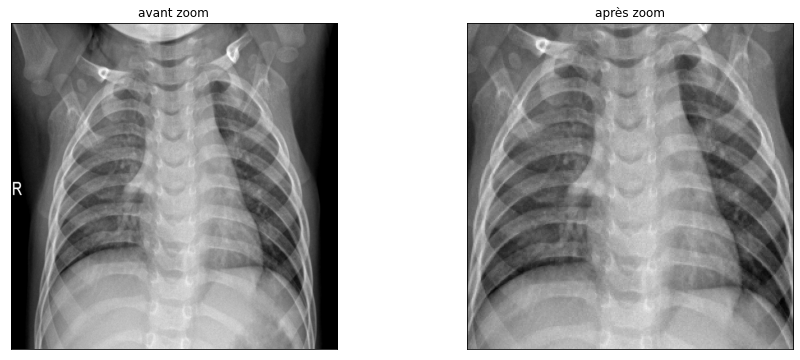

In [45]:
liste_normal = glob.glob(old_path+"/Normal/*")

plt.figure(figsize=(15,6))

plt.subplot(121)
radio_normal=plt.imread(liste_normal[(floor(random.uniform(0,1)*len(liste_normal)))])
plt.imshow(radio_normal,cmap='gray');
plt.xticks([]);
plt.yticks([]);
plt.title("avant zoom");


plt.subplot(122)
long, larg = radio_normal.shape[:2]
long_z = int(0.8*long)
larg_z = int(0.8*larg)
long_deb = int(0.1*long)
larg_deb = int(0.1*larg)
img_zoom = radio_normal[long_deb:long_deb + long_z, larg_deb:larg_deb + larg_z]
img_zoom = cv2.resize(img_zoom, dsize = (256,256))
plt.imshow(img_zoom,cmap='gray')
plt.xticks([]);
plt.yticks([]);
plt.title("après zoom");

On constate que la transformation morphologique à permis un centrage des radiographies sur les poumons, tout en éliminant les bords noirs. Les radiographies sont tronquées de 10% sur les parties hautes, basses et latérales.

### Chargement des radiographies dans un DataFrame

In [46]:
# Extraire le label de chaque image
def extract_image_info(path):
    type_image = ''
    if 'COVID' in path:
        type_image = 'Covid'
    elif 'Pneumonia' in path:
        type_image = 'Pneumonia'
    else:
        type_image = 'Normal'
    return path, type_image


# Trouver tous les chemins vers les fichiers qui finissent par .png
liste = glob.glob(old_path+"\*\*.png")

# Extraire le label de chaque image
liste = list(map(lambda path :extract_image_info(path), liste))

# Créer un dataframe pandas
df = pd.DataFrame(liste, columns=['filepath', 'nameLabel'])
df['label'] = df['nameLabel'].replace(df['nameLabel'].unique(), [*range(len(df['nameLabel'].unique()))])

### Affichage du dataframe

In [47]:
df

,filepath,nameLabel,label
0,../Data\COVID-19\COVID-19 (10).png,Covid,0
1,../Data\COVID-19\COVID-19 (100).png,Covid,0
2,../Data\COVID-19\COVID-19 (1000).png,Covid,0
3,../Data\COVID-19\COVID-19 (1001).png,Covid,0
4,../Data\COVID-19\COVID-19 (1002).png,Covid,0
...,...,...,...
3800,../Data\Viral Pneumonia\Viral Pneumonia (995).png,Pneumonia,2
3801,../Data\Viral Pneumonia\Viral Pneumonia (996).png,Pneumonia,2
3802,../Data\Viral Pneumonia\Viral Pneumonia (997).png,Pneumonia,2
3803,../Data\Viral Pneumonia\Viral Pneumonia (998).png,Pneumonia,2


### Lire et charger les images originales 

In [49]:
def read_image(path):
    img = cv2.imread(path)
    if img.shape == (256,256):
        img_ret = img
    else :
        img_ret = cv2.resize(img, dsize = (256,256))
    return img_ret

original_data = [read_image(df['filepath'][k]) for k in range(df.shape[0])]
original_target = df["label"].tolist()

### Génération d'un jeu d'entrainement et d'un jeu de test

In [50]:
X_train, X_test, y_train, y_test = train_test_split(original_data, original_target, train_size=0.8, random_state=1)

### Traitement, Transformation du Train

Ci dessous, nous nous proposons de faire une transformation du dataset de train, visant à réduire les bordures. Pour ce qui concerne le dataset de test, il restera inchangé.

In [51]:
def transform(original_data, original_target, transformed_data, transformed_target):
    for index in range(0, len(original_data)):
        original_image = original_data[index]
        original_class = original_target[index]
        
        # Si image Covid et que la moyenne est > = 0.5 on ne fait pas de transformation
        #if (original_class == 0 and original_image.mean() >= 0.5):
        #    continue
        
        long, larg = original_image.shape[:2]
        long_z = int(0.8*long)
        larg_z = int(0.8*larg)
        long_deb = int(0.1*larg)
        larg_deb = int(0.1*larg) 
        img_zoom = original_image[long_deb:long_deb + long_z, larg_deb:larg_deb + larg_z]
        img_zoom = cv2.resize(img_zoom, dsize = (256,256))
        
        transformed_data.append(img_zoom)
        transformed_target.append(original_class)

# Nouvelle liste contentant les images du train avec Zoom
transformed_data = []     
transformed_target = []

transform(X_train, y_train, transformed_data, transformed_target)

### Constuire un nouveau dataset pour le train,contenant le train d'origine ainsi que la transformation

In [53]:
data = []
data.extend(X_train)
data.extend(transformed_data)

target = []
target.extend(y_train)
target.extend(transformed_target)

##### ---------------------------------------------------------------------------------------------------------------
# PARTIE 2: MODELISATIONS
##### ---------------------------------------------------------------------------------------------------------------

### Normalisation du jeu de données d'entrainement et de validation

In [54]:
X_train=np.array(data)/255 
X_test=np.array(X_test)/255

### Taille du jeu de données d'entrainement et de validation

In [55]:
X_train.shape

(6088, 256, 256, 3)

In [56]:
X_test.shape

(761, 256, 256, 3)

### Encodage de la variable cible

In [57]:
y_train_categorial = utils.to_categorical(target)
y_test_categorial = utils.to_categorical(y_test)

### Fonctions helper

##### Fonction d'export en fichier text

Cette fonction permet d'export le content text en un fichier de type txt

In [59]:
def export_to_text_file(content, name, folder_destination):
    file = open(f'{folder_destination}/{name}.txt', "w")
    file.write(content)
    file.close()

##### Classification report

Cette fonction permet d'avoir le classificaiton report

In [61]:
def classification(y_pred, y_test, folder_destination):
    report = classification_report(y_test, y_pred, target_names=list(df['nameLabel'].unique()))
    export_to_text_file(report, 'classification_report', folder_destination)
    print(report)

##### Confusion matrix

Cette fonction permet l'affichage de la matrice de confusion 

In [62]:
def confusion(y_pred, y_test, folder_destination):
    
    cm=confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar() 
    tick_marks = np.arange(len(list(df['nameLabel'].unique())))
    plt.xticks(tick_marks, list(df['nameLabel'].unique()))
    plt.yticks(tick_marks, list(df['nameLabel'].unique()))
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > ( cm.max() / 2) else "black")
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    
    plt.savefig(f'./{folder_destination}/confusion_matrix.png')  

##### Courbes de précision et de perte

Cette fonction permet l'affichage des courbes de précision et de perte sur les données d'entrainement et sur les données de test.

In [63]:
def precision_perte(history, folder_destination):
    
    train_acc = history.history["accuracy"]
    valid_acc = history.history["val_accuracy"]
    
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.plot(np.arange(1,len(train_acc)+1), train_acc)
    plt.plot(np.arange(1,len(train_acc)+1), valid_acc)
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.title("Training et Validation Accuracy")
    plt.grid()
    plt.xlim([1,len(train_acc)]);
    plt.xlabel("Epoch");
    
    plt.subplot(1,2,2)
    train_loss = history.history["loss"]
    valid_loss = history.history["val_loss"]
    plt.plot(np.arange(1,len(train_loss)+1), train_loss)
    plt.plot(np.arange(1,len(train_loss)+1), valid_loss)
    plt.legend(["Training loss", "Validation loss"])
    plt.title("Training et Validation loss")
    plt.grid()
    plt.xlim([1,len(train_loss)]);
    plt.xlabel("Epoch");
    
    plt.savefig(f'./{folder_destination}/loss_accuracy.png')  

##### Sauvgarde du Modèle

Cette fonction permet de sauvegarder notre modèle sur notre machine, elle export aussi le summary sous format de fichier

In [64]:
def save_model(model, folder_destination):
    # Récuperer le contenu summary du modèle et le Stocker dans un fichier text
    stream = io.StringIO()
    # récupérer le contenu du summary dans la variable stream
    model.summary(print_fn=lambda x: stream.write(x + '\n'))
    # extraire le texte du stream
    summary = stream.getvalue()
    stream.close()
    export_to_text_file(summary, 'summary', folder_destination)
    
    # Stocker le modèle en local pour une utilisation ultérieur (Démo...)
    model.save(f'./{folder_destination}')

##### Fonction d'évaluation

Cette fonction permet la synthèse des 3 fonctions précédentes en permettant l'affichage du rapport de classifiaction, de la matrice de confusion, des courbes de précisions et de pertes.

In [65]:
def evaluate(model, y_pred, y_test, history, folder_destination):
    classification(y_pred, y_test, folder_destination)
    confusion(y_pred,y_test, folder_destination)
    precision_perte(history, folder_destination)
    save_model(model, folder_destination)

# MODELISATION 1 : CNN LeNet

Cette première modélisation fait appel à une architecture basée sur "LeNet", un réseau de neurones convolutifs, caractérisé par une alternance de couche de convolution et de pooling, permettant l'extraction des caractéristiques des radiographies. La classification est assurée par une couche dense de réseau de neurones connectés.

### Architecture du modèle

In [66]:
model = Sequential()

# couche de convulotion+pooling
model.add(Conv2D(filters = 30,
                 kernel_size = (5,5),
                 input_shape=(256,256,3), 
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 16,
                 kernel_size = (3,3),
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# dropout pour éviter l'overfitting
model.add(Dropout(rate=0.2))

model.add(Flatten())

# couche de neurones complètement connectés
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

### Résumé du CNN 

In [67]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_310 (Conv2D)          (None, 252, 252, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 30)      0         
_________________________________________________________________
conv2d_311 (Conv2D)          (None, 124, 124, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

### Compilation du modèle

In [68]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

### Entrainement du modèle

In [69]:
epochs=10
batch_size=32

history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epochs, batch_size=batch_size)

Epoch 1/10
153/153 [==============================] - 268s 2s/step - loss: 1.0976 - accuracy: 0.6783 - val_loss: 0.6279 - val_accuracy: 0.7250
Epoch 2/10
153/153 [==============================] - 196s 1s/step - loss: 0.3176 - accuracy: 0.8884 - val_loss: 0.3913 - val_accuracy: 0.8432
Epoch 3/10
153/153 [==============================] - 195s 1s/step - loss: 0.2242 - accuracy: 0.9192 - val_loss: 0.3585 - val_accuracy: 0.8555
Epoch 4/10
153/153 [==============================] - 196s 1s/step - loss: 0.2153 - accuracy: 0.9232 - val_loss: 0.4226 - val_accuracy: 0.8415
Epoch 5/10
153/153 [==============================] - 190s 1s/step - loss: 0.1623 - accuracy: 0.9461 - val_loss: 0.3140 - val_accuracy: 0.8859
Epoch 6/10
153/153 [==============================] - 194s 1s/step - loss: 0.1022 - accuracy: 0.9639 - val_loss: 0.2544 - val_accuracy: 0.9154
Epoch 7/10
153/153 [==============================] - 191s 1s/step - loss: 0.0654 - accuracy: 0.9832 - val_loss: 0.3131 - val_accuracy: 0.9015

### Affichage des résultats

              precision    recall  f1-score   support

       Covid       0.96      0.95      0.96       238
      Normal       0.89      0.95      0.92       258
   Pneumonia       0.95      0.88      0.91       265

    accuracy                           0.93       761
   macro avg       0.93      0.93      0.93       761
weighted avg       0.93      0.93      0.93       761

INFO:tensorflow:Assets written to: ./LeNet\assets


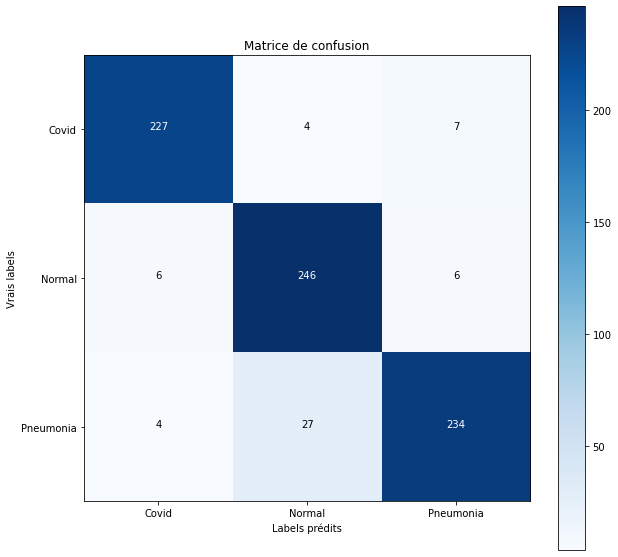

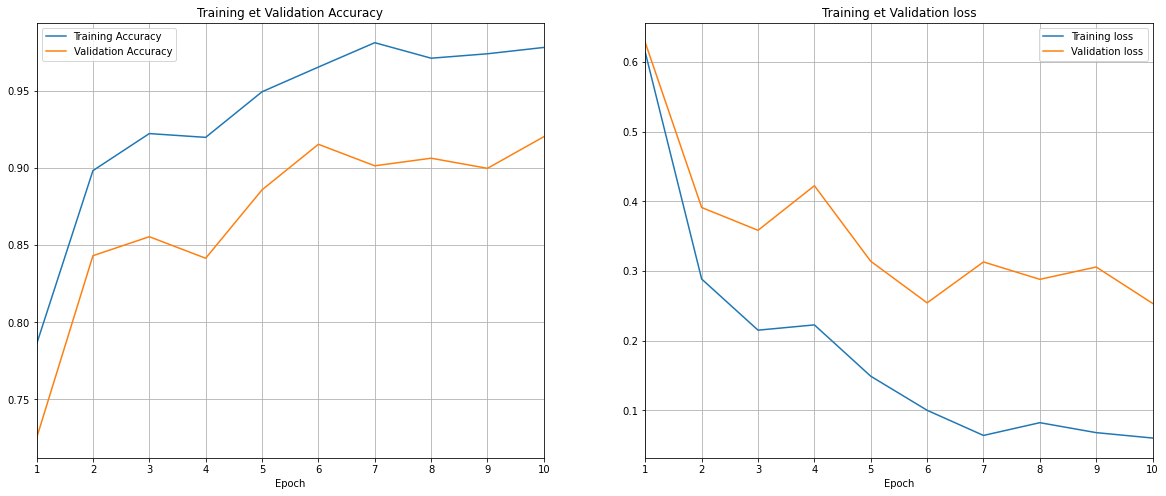

In [70]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test_categorial, axis=1)

evaluate(model, y_pred, y_test, history, FOLDER_LENET)

# MODELISATION 2: CNN personnalisé

Cet deuxième modélisation est un ensemble de deux modèles personnalisés par l'équipe, caractérisés par une alternance de couche de convolution et de pooling, permettant l'extraction des caractéristiques des radiographies. La classification est assurée par une couche dense de réseau de neurones connectés.

## CNN personnalisé Architecture 1

Cette seconde architecture utilise une CategoricalCrossentropy comme loss function.

### Architecture du modèle

In [76]:
model = Sequential()

# couche de convolution
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=[256, 256, 3]))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.05))

# couche de neurone complètement connéctées
model.add(Dense(units=32, activation ="relu"))
model.add(Dense(units=16, activation ="relu"))
model.add(Dense(units=3, activation='softmax'))

### Résumé du modèle

In [77]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_314 (Conv2D)          (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_315 (Conv2D)          (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8388672   
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

### Paramètrage de la métrique d'optimisation

In [78]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=6000, decay_rate=0.95, staircase=True)

### Compilation du modèle

In [79]:
model.compile(optimizer=Adam(learning_rate = lr_schedule), loss = CategoricalCrossentropy(), metrics=['accuracy'])

### Entrainement du modèle

In [80]:
epochs = 10
batch_size = 32
history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epochs, batch_size=batch_size)

Epoch 1/10
153/153 [==============================] - 334s 2s/step - loss: 0.9197 - accuracy: 0.5939 - val_loss: 0.3577 - val_accuracy: 0.8612
Epoch 2/10
153/153 [==============================] - 296s 2s/step - loss: 0.3137 - accuracy: 0.8919 - val_loss: 0.3342 - val_accuracy: 0.8736
Epoch 3/10
153/153 [==============================] - 299s 2s/step - loss: 0.2635 - accuracy: 0.9045 - val_loss: 0.3033 - val_accuracy: 0.8834
Epoch 4/10
153/153 [==============================] - 296s 2s/step - loss: 0.1859 - accuracy: 0.9306 - val_loss: 0.2927 - val_accuracy: 0.8892
Epoch 5/10
153/153 [==============================] - 299s 2s/step - loss: 0.1354 - accuracy: 0.9510 - val_loss: 0.3497 - val_accuracy: 0.8612
Epoch 6/10
153/153 [==============================] - 295s 2s/step - loss: 0.1317 - accuracy: 0.9539 - val_loss: 0.2482 - val_accuracy: 0.9113
Epoch 7/10
153/153 [==============================] - 294s 2s/step - loss: 0.0980 - accuracy: 0.9667 - val_loss: 0.2195 - val_accuracy: 0.9187

### Affichage des résultats

              precision    recall  f1-score   support

       Covid       0.95      0.99      0.97       238
      Normal       0.96      0.91      0.93       258
   Pneumonia       0.94      0.94      0.94       265

    accuracy                           0.95       761
   macro avg       0.95      0.95      0.95       761
weighted avg       0.95      0.95      0.95       761

INFO:tensorflow:Assets written to: ./Perso 1\assets


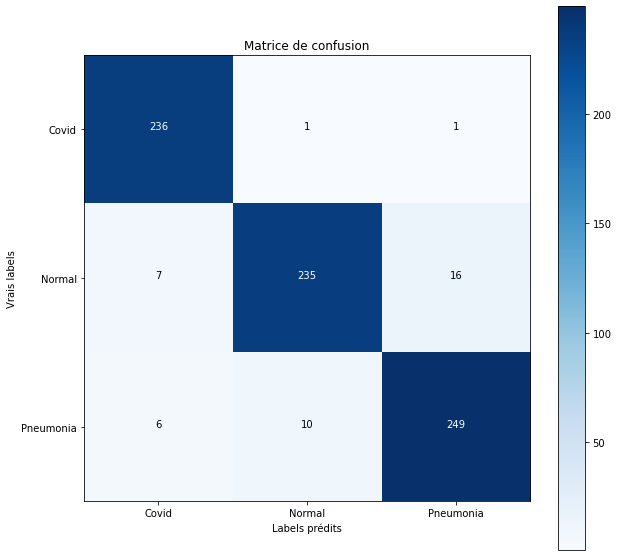

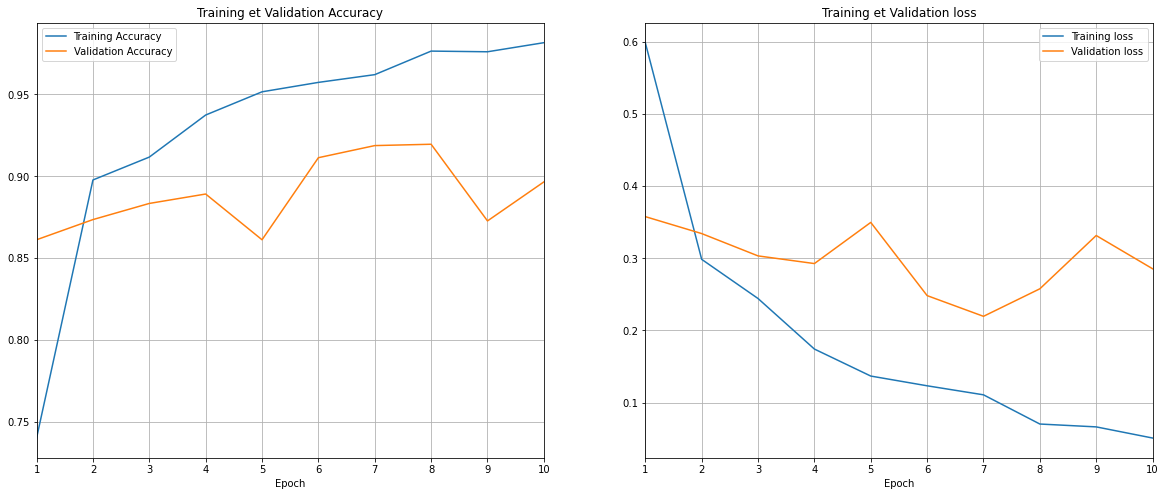

In [81]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test_categorial, axis=1)


evaluate(model, y_pred, y_test, history, FOLDER_PERSO_1)

## CNN personnalisé Architecture 2

Cette seconde architecture utilise une SparseCategoricalCrossentropy comme loss function.

### Architecture du modèle

In [108]:
model = Sequential()

# couche de convolution
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=[256, 256, 3]))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.05))

# couche de neurone complètement connéctées
model.add(Dense(units=32, activation ="relu"))
model.add(Dense(units=16, activation ="relu"))
model.add(Dense(units=3, activation='softmax'))

### Résumé du modèle

In [109]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_323 (Conv2D)          (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_324 (Conv2D)          (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8388672   
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)               

### Paramètrage de la métrique d'optimisation

In [110]:
learning_rate = 0.01

### Compilation du modèle

In [111]:
model.compile(optimizer=Adam(learning_rate = learning_rate), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

###  Conversion du y_train

In [112]:
y_train_sparse = np.array(target)

### Entrainement du modèle

In [114]:
epochs = 10
batch_size = 32

# SparseCategoricalCrossentropy on utilise les classes sans transformation
#history = model.fit(X_train, y_train_sparse, validation_split=0.2, epochs=epochs, batch_size=batch_size)

### Affichage des résultats

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)


evaluate(model, y_pred, y_test, history, FOLDER_PERSO_2)

# MODELISATION 3: Transfer Learning avec EfficientNetB5

Cette troisième modélisation est basé sur le principe du transfer learning qui consiste à utiliser un modèle pré-entrainé sur des centaines de milliers d'image. Le modèle pré-entrainé choisi est EfficientNetB5, il permet l'extraction des caractéristiques des radiographies. La classification est assurée par une couche dense de réseau de neurones connectés.

### Chargement du modèle pré-entrainé EfficientNetB5

In [115]:
from keras_efficientnets import EfficientNetB5

base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

### Couches de convolution de EfficientNetB5  "freezer"

In [116]:
for layer in base_model.layers:
    layer.trainable = False 

### Ajout des couches de convolution de EfficientNetB5

In [117]:
model=Sequential()
model.add(base_model)

### Ajout des couches de classification fully connected

In [118]:
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(3, activation='softmax'))

### Résumé du CNN 

In [119]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 8, 8, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 3)               

### Compilation du modèle

In [36]:
#model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

### Entrainement du modèle

In [120]:
epoch = 10
batch_size = 32

#history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epoch, batch_size=batch_size) 

## Fine tuning

Le fine tuning permet d'adapter les 3 dernières couches de convolutions du modèles pré-entrainé, à nos données. Ce réglage fin permet une meilleur extraction des caractéristiques des radiographies.

### 'Unfreeze' des 3 dernières couches de convolutions de EfficientNetB5

In [122]:
for layer in base_model.layers[-3:]:
    layer.trainable = True

### Nouvelle compilation du modèle

In [123]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',metrics=['accuracy'])

### Nouvel entrainement du modèle

In [124]:
epoch = 10
batch_size = 32

history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epoch, batch_size=batch_size) 

Epoch 1/10
153/153 [==============================] - 1204s 7s/step - loss: 0.4351 - accuracy: 0.8424 - val_loss: 0.1852 - val_accuracy: 0.9319
Epoch 2/10
153/153 [==============================] - 1025s 7s/step - loss: 0.1456 - accuracy: 0.9485 - val_loss: 0.1157 - val_accuracy: 0.9614
Epoch 3/10
153/153 [==============================] - 1024s 7s/step - loss: 0.0952 - accuracy: 0.9622 - val_loss: 0.1073 - val_accuracy: 0.9589
Epoch 4/10
153/153 [==============================] - 1022s 7s/step - loss: 0.0657 - accuracy: 0.9779 - val_loss: 0.0967 - val_accuracy: 0.9655
Epoch 5/10
153/153 [==============================] - 1031s 7s/step - loss: 0.0485 - accuracy: 0.9870 - val_loss: 0.0887 - val_accuracy: 0.9680
Epoch 6/10
153/153 [==============================] - 1040s 7s/step - loss: 0.0444 - accuracy: 0.9848 - val_loss: 0.0947 - val_accuracy: 0.9672
Epoch 7/10
153/153 [==============================] - 21927s 144s/step - loss: 0.0284 - accuracy: 0.9906 - val_loss: 0.0832 - val_accura

### Affichage des résultats

              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00       238
      Normal       0.95      0.97      0.96       258
   Pneumonia       0.97      0.95      0.96       265

    accuracy                           0.97       761
   macro avg       0.97      0.97      0.97       761
weighted avg       0.97      0.97      0.97       761

INFO:tensorflow:Assets written to: ./EfficientNetB5\assets


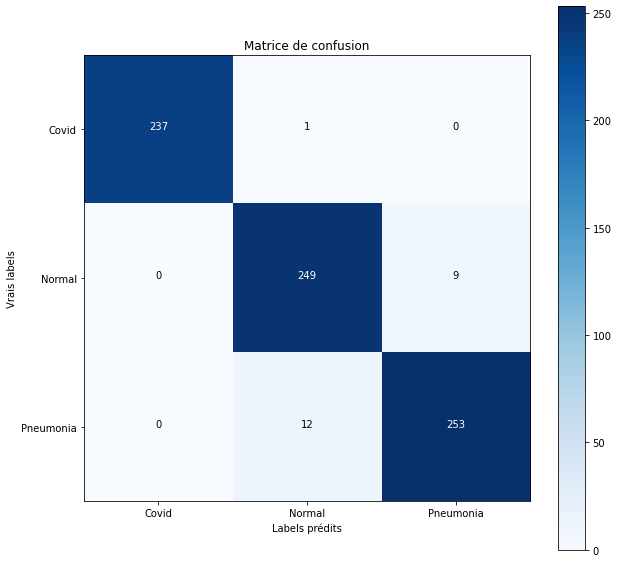

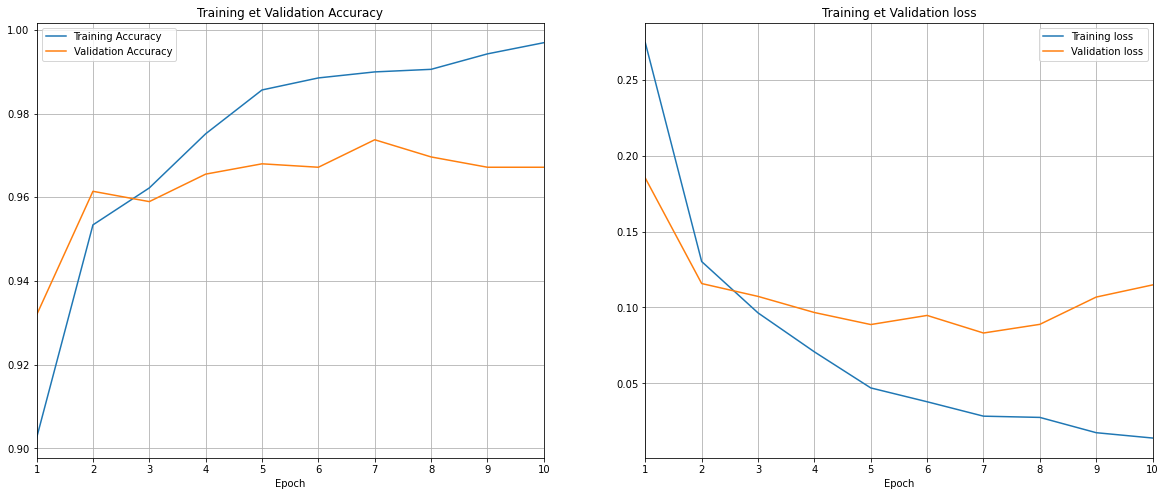

In [125]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_test = np.argmax(y_test_categorial,axis=1)


evaluate(model, y_pred, y_test, history, FOLDER_EFFICIENT)

 # MODELISATION 4: FEATURE EXTRACTION

Cette quatrième modélisation combine les techniques de deep learning et de machine learning. Un modèle pré-entrainé, InceptionV3, est utilisé pour extraire les caractéristiques des radiographies et un XGBoostClassifier est utilisé pour opérer la classification en sortie du modèle pré-entrainé. 

### Chargement du modèle pré-entrainé InceptionV3

In [126]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape=(256,256,3), weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 3s 0us/step


### Couches de convolution de InceptionV3  "freezer"

In [127]:
for layer in base_model.layers:
    layer.trainable = False 

### Ajout des couches de convolution de InceptionV3

In [128]:
model=Sequential()
model.add(base_model)

### Ajout des couches de classification fully connected

In [129]:
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(3, activation='softmax'))

### Résumé du CNN 

In [130]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 3)               

### Compilation du modèle

In [131]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

### Entrainement du modèle

In [132]:
epoch = 10
batch_size = 32
 
history = model.fit(X_train, y_train_categorial, validation_split=0.2, epochs=epoch, batch_size=batch_size) 

Epoch 1/10
153/153 [==============================] - 411s 3s/step - loss: 0.8069 - accuracy: 0.7371 - val_loss: 0.2729 - val_accuracy: 0.8982
Epoch 2/10
153/153 [==============================] - 341s 2s/step - loss: 0.2442 - accuracy: 0.9069 - val_loss: 0.1900 - val_accuracy: 0.9351
Epoch 3/10
153/153 [==============================] - 354s 2s/step - loss: 0.1945 - accuracy: 0.9292 - val_loss: 0.1899 - val_accuracy: 0.9310
Epoch 4/10
153/153 [==============================] - 360s 2s/step - loss: 0.1755 - accuracy: 0.9349 - val_loss: 0.1823 - val_accuracy: 0.9319
Epoch 5/10
153/153 [==============================] - 361s 2s/step - loss: 0.1626 - accuracy: 0.9415 - val_loss: 0.1732 - val_accuracy: 0.9310
Epoch 6/10
153/153 [==============================] - 365s 2s/step - loss: 0.1949 - accuracy: 0.9269 - val_loss: 0.2141 - val_accuracy: 0.9171
Epoch 7/10
153/153 [==============================] - 384s 3s/step - loss: 0.1772 - accuracy: 0.9368 - val_loss: 0.1434 - val_accuracy: 0.9466

### Connexion aux dernières couches du modèle

In [133]:
intermediate_layer_model = Model(model.input, model.layers[2].output)
X_train_feature = intermediate_layer_model.predict(preprocess_input(X_train))
X_test_feature = intermediate_layer_model.predict(preprocess_input(X_test))

### Affichage des résultats

In [134]:
xgb = XGBClassifier()
xgb.fit(X_train_feature, np.argmax(y_train_categorial, axis=1))

[12:00:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [135]:
print('score:', xgb.score(X_test_feature, np.argmax(y_test_categorial, axis=1)))

score: 0.897503285151117


In [136]:
y_pred = xgb.predict(X_test_feature)
y_test = np.argmax(y_test_categorial,axis=1)

              precision    recall  f1-score   support

       Covid       0.95      0.95      0.95       238
      Normal       0.85      0.93      0.89       258
   Pneumonia       0.90      0.82      0.86       265

    accuracy                           0.90       761
   macro avg       0.90      0.90      0.90       761
weighted avg       0.90      0.90      0.90       761



['./InceptionV3/xgb.joblib']

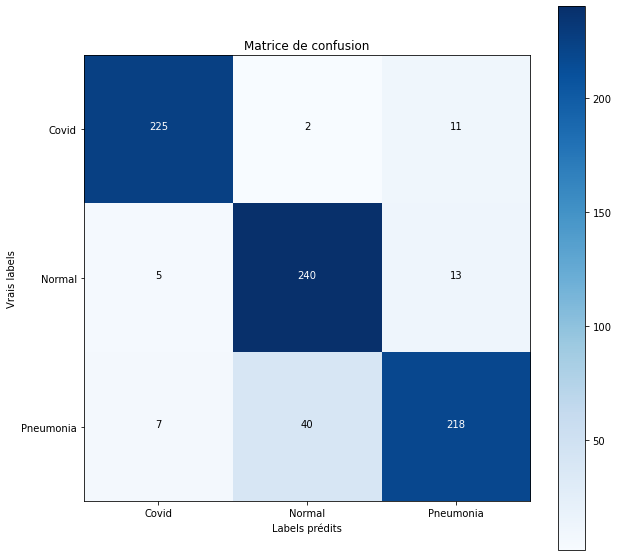

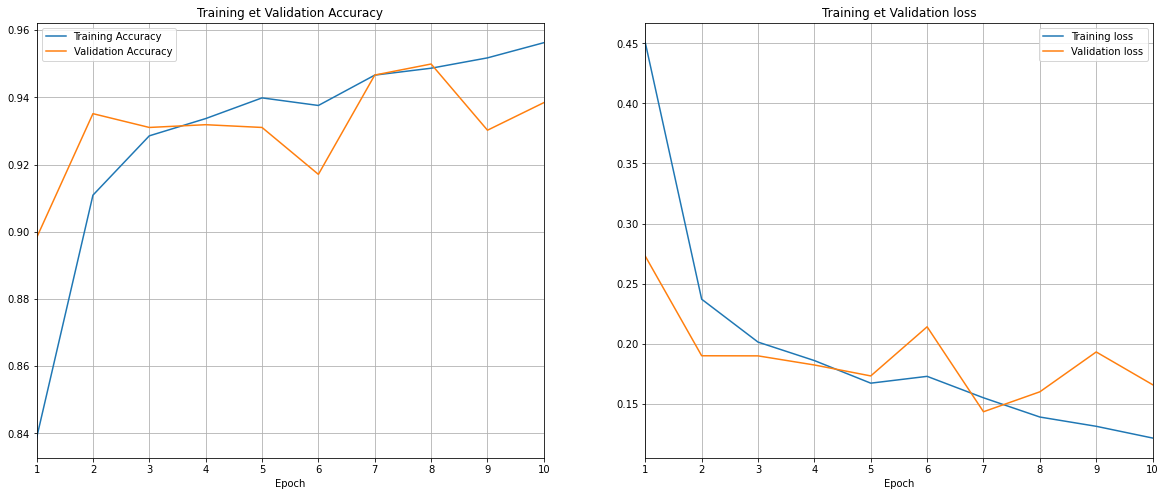

In [137]:
def classification_ml(y_pred,y_test):
    report = classification_report(y_test, y_pred, target_names=list(df['nameLabel'].unique()))
    export_to_text_file(report, 'classification_report', FOLDER_INCEPTION)
    print(report)

def confusion_ml(y_pred,y_test):
    cm=confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar() 
    tick_marks = np.arange(len(list(df['nameLabel'].unique())))
    plt.xticks(tick_marks, list(df['nameLabel'].unique()))
    plt.yticks(tick_marks, list(df['nameLabel'].unique()))
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > ( cm.max() / 2) else "black")
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.savefig(f'./{FOLDER_INCEPTION}/confusion_matrix.png')  

def precision_perte_ml(history):
    
    train_acc = history.history["accuracy"]
    valid_acc = history.history["val_accuracy"]
    
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.plot(np.arange(1,len(train_acc)+1), train_acc)
    plt.plot(np.arange(1,len(train_acc)+1), valid_acc)
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.title("Training et Validation Accuracy")
    plt.grid()
    plt.xlim([1,len(train_acc)]);
    plt.xlabel("Epoch");
    
    plt.subplot(1,2,2)
    train_loss = history.history["loss"]
    valid_loss = history.history["val_loss"]
    plt.plot(np.arange(1,len(train_loss)+1), train_loss)
    plt.plot(np.arange(1,len(train_loss)+1), valid_loss)
    plt.legend(["Training loss", "Validation loss"])
    plt.title("Training et Validation loss")
    plt.grid()
    plt.xlim([1,len(train_loss)]);
    plt.xlabel("Epoch");
    plt.savefig(f'./{FOLDER_INCEPTION}/loss_accuracy.png') 
    
def affichage_ml(y_pred,y_test,history):
    classification_ml(y_pred,y_test)
    confusion_ml(y_pred,y_test)
    precision_perte_ml(history)

affichage_ml(y_pred, y_test, history)

from joblib import dump, load
dump(xgb, f'./{FOLDER_INCEPTION}/xgb.joblib') 

In [138]:
save_model(model, FOLDER_INCEPTION)

INFO:tensorflow:Assets written to: ./InceptionV3\assets
